Create simulation of landing particles

In [43]:
import numpy as np
import math
import matplotlib.pyplot as plt
import time

from scipy.stats import norm
import scipy.stats as st
import statistics
import matplotlib.mlab as mlab
from lmfit.models import GaussianModel
from lmfit.models import LorentzianModel

class Landing_Flashes:
    """
    Generates a stack of images corresponding to landing of Brownian particles, assuming each particles lands in single frame (no time trace).

    Parameters
    ----------
    :fov: [width, height] of the desired image that contains these particles
    :bgframe: stationary background image given as input
    Returns
    -------
    :return: .loca: intended location of the particles (with sub-pixel resolution)
             .stack: a stack of images with specified noise and particles displaced accordingly
    """
    def __init__(self, seed = 300, fov = [300, 200], nframes=10, numpar = 20, signal = 10.0, sizevar = 0.3, normalvar = False, noise = 1.0, bgframe = [None], dark = 100, psize = 6, unevenIllumination = False, irefmode = 2):
        # camera and monitor parameters
        self.seed = seed #seeding for the particles, to generate the same set each time
        self.xfov, self.yfov = fov
        self.numpar = numpar # Desired number of landing particles
        self.nframes = nframes # Desired number of recorded images
        self.signal = signal # brightness for each particle
        self.sizevar = sizevar # width of the size distribution assuming a square histogram
        self.noise = noise # background noise
        self.psize = psize # diameter of each particle in the image, currently must be integer
        self.parlist = []  # ground truth for the particle location
        
        if unevenIllumination:
            self.iref = self.genIref(irefmode)
        else:
            self.iref = np.ones(fov)

        self.psf = self.initPSF(psize)
        if bgframe == [None]:
            self.bg = self.genBG(dark, noise)
        else:
            self.bg = bgframe
        
        np.random.seed(self.seed)
        ts = np.random.uniform(0, numpar, size=(self.nframes, 1))
        self.nlanded = np.sort(ts.astype(int), axis=0)
        
        if normalvar:
            self.loca = self.initLocations_normal()
        else:
            self.loca = self.initLocations()

    def genBG(self, dar, noi):
        """
        generates constant noisy background with extra dark signal
        """
        np.random.seed(self.seed)
        bg = np.random.poisson(noi, size = (self.xfov, self.yfov)) + dar
        ffbg = np.fft.rfft2(bg)
        max_freq = int(self.xfov / self.psize)
        ffbg[max_freq:, max_freq:] = 0
        bg = abs(np.fft.irfft2(ffbg))

        return bg

    def genIref(self, md):
        """
        generates uneven illumination pattern
        """
        cox, coy = np.meshgrid(np.arange(self.xfov)/self.xfov, np.arange(self.yfov)/self.yfov, indexing='ij')
        ir = self.noise*np.sin(2*np.pi*md*(cox+coy))+self.signal

        return ir
        
    def initPSF(self, p):
        psf = np.zeros((2*p,2*p))
        for n in range(p):
            for m in range(p):
                psf[p+n,p+m] = psf[p-n-1,p+m] = psf[p+n,p-m-1] = psf[p-n-1,p-m-1] = np.exp(-np.sqrt(n**2+m**2)/p)
        return psf
        

    def initLocations(self):
        # initializes the random location of numpar particles in the frame. one can add more paramaters like intensity
        # and PSF distribution if necessary
        np.random.seed(self.seed)
        p = self.psize
        parx = np.random.uniform(2*p, self.xfov-2*p, size=(self.numpar, 1))
        pary = np.random.uniform(2*p, self.yfov-2*p, size=(self.numpar, 1))
        pari = np.random.uniform(self.signal*(1-self.sizevar/2), self.signal*(1+self.sizevar/2), size=(self.numpar, 1))

        lp = np.concatenate((parx, pary, pari), axis=1)
        self.parlist = lp

        return lp

    def initLocations_normal(self):
        # initializes the random location of numpar particles in the frame. one can add more paramaters like intensity
        # and PSF distribution if necessary
        np.random.seed(self.seed)
        p = self.psize
        parx = np.random.uniform(2*p, self.xfov-2*p, size=(self.numpar, 1))
        pary = np.random.uniform(2*p, self.yfov-2*p, size=(self.numpar, 1))
        pari = np.random.normal(self.signal, self.sizevar, size=(self.numpar, 1))

        lp = np.concatenate((parx, pary, pari), axis=1)
        self.parlist = lp

        return lp
    
    def genImage(self,npar):
        """
        :return: generated image with specified position in self.loca up to particle number n
        """
        simimage = np.copy(self.bg)
        psize = self.psize
        if npar > self.numpar:
            m = self.numpar
        else:
            m = int(npar)
        for n in range(m):
            x = int(self.loca[n,0])
            y = int(self.loca[n,1])
            simimage[x-psize:x+psize, y-psize:y+psize] = simimage[x-psize:x+psize, y-psize:y+psize] + self.psf * self.loca[n,2]

        simimage = np.multiply(simimage,self.iref)
        return simimage


    def genStack(self):
        """
        Using all the above methods in this class, this method only iterates enough to create a stack of synthetic frames
        that can be analyzed later

        :param nframes: number of frames to generate
        :return: simulated data
        """
        np.random.seed(self.seed)
        numpar = self.numpar
        nf = self.nframes
#         data = np.zeros((self.xfov, self.yfov, nf))
        data = np.zeros((nf,self.xfov, self.yfov))


        for n in range(nf):
            l = np.random.poisson(self.noise, size = (self.xfov, self.yfov))
            npar = self.nlanded[n]
#             data[:,:,n] = np.multiply(self.genImage(npar), l)
            data[n,:,:] = (self.genImage(npar) + l)
        return data

#         Changed it to (n,x,y) format
        


Enter the variables for the simulation

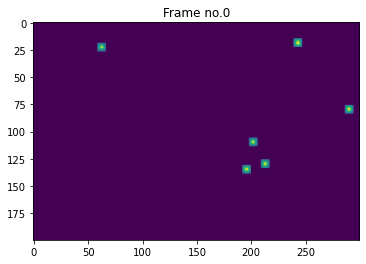

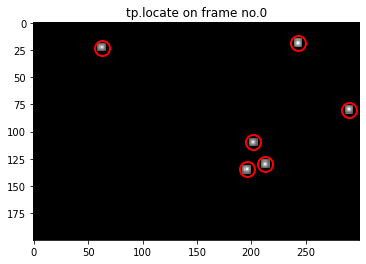

6


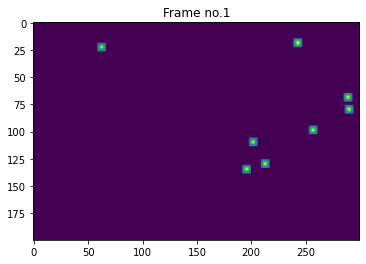

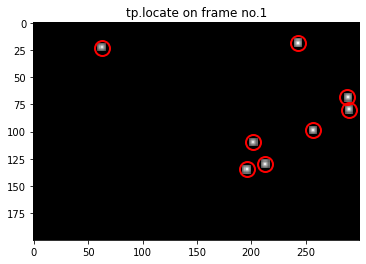

8


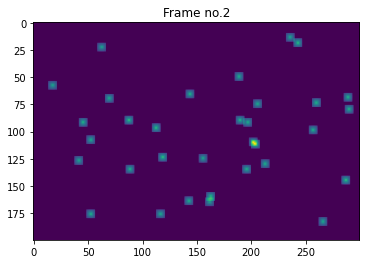

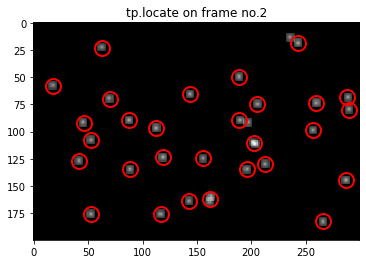

29


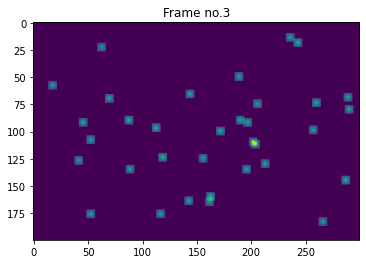

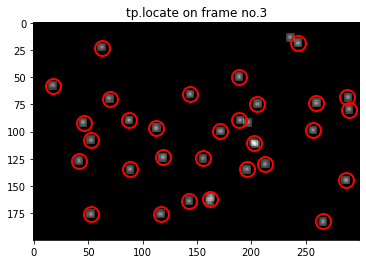

30


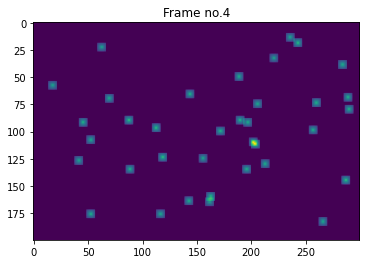

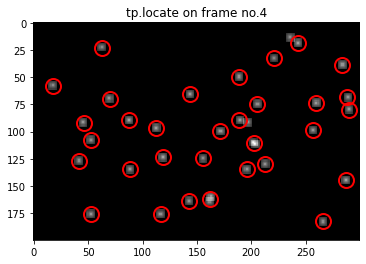

32


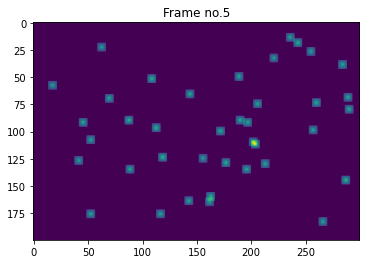

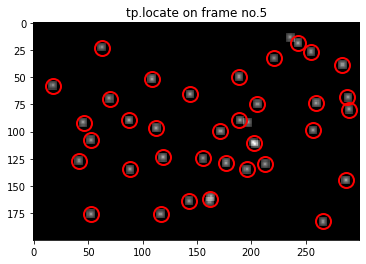

35


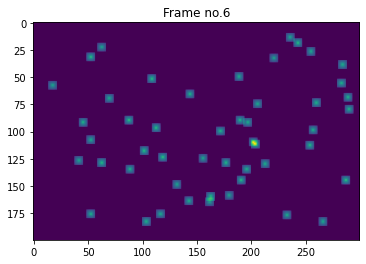

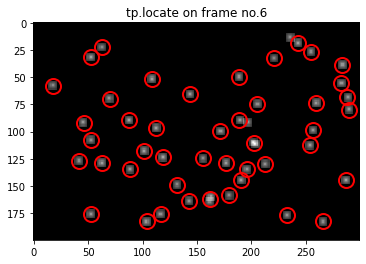

45


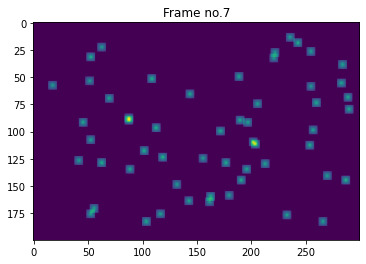

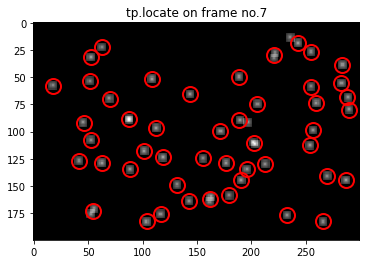

48


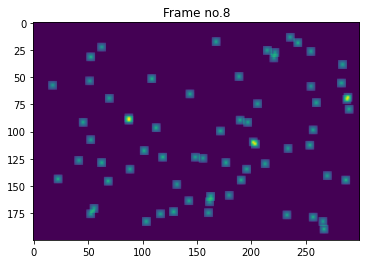

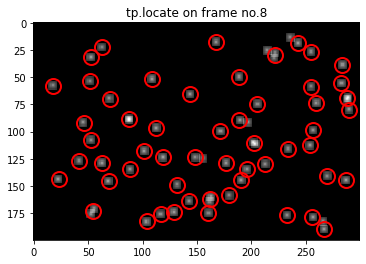

55


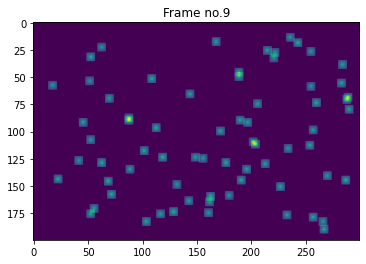

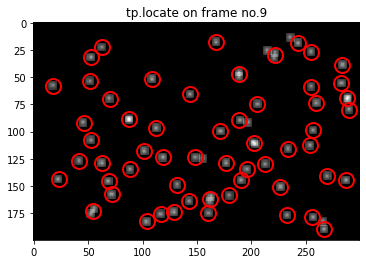

57


In [46]:
import trackpy
nf = 10 # number of frames
meas = Landing_Flashes(fov=[200,300],seed=500, numpar = 100, noise = 0, nframes = nf, signal = 20, sizevar=0.2, dark = 5, psize = 4, unevenIllumination = False)
# =======================================

plis = meas.parlist
# print(plis)
# print(np.shape(plis))
list1 = plis[:,2]
# print(list1)
# print(len(list1))
a = min(list1)
b = max(list1)

# uncomment lines below to show and save simulation frames to a folder of choice
sig = meas.genStack()
im = plt.imshow(sig[-1,:,:])
# f = trackpy.locate(sig[-1,:,:], 9, minmass = 50, invert = False)
# trackpy.annotate(f, sig[-1,:,:]);
# print(len(f['mass']))
for i in range(nf):
    plt.imshow(sig[i,:,:])
    plt.title(f'Frame no.{i}')
    time.sleep(0.01)
#     save_results_to = 'C:/Users/brugg/Imagesnew/simulation/'
#     plt.savefig(save_results_to + f'image{i}.png', dpi=300)
    plt.imshow(sig[i,:,:])
    plt.show()
    plt.title(f'tp.locate on frame no.{i}')
    f = trackpy.locate(sig[i,:,:], 9, minmass = 50, invert = False)
    trackpy.annotate(f, sig[i,:,:]);
    print(len(f['mass']))
    plt.show()


In [8]:
# f_2 = trackpy.batch(sig[:,:,:,], 9,  invert = False)
f_2 = trackpy.batch(sig[:,:,:,], 9, invert=False, minmass=20, processes='auto')
f_2

Frame 9: 20 features


,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,134.661162,250.661162,186.844074,2.405331,0.043611,7.152866,786.428145,6.226962e-18,0
1,18.661162,144.661162,212.688889,2.405331,0.043611,8.142271,861.320056,5.463443e-18,1
2,134.661594,250.661594,186.729413,2.405179,0.043631,7.152426,786.428145,6.219162e-18,1
3,18.660630,144.660630,212.434638,2.405047,0.043548,8.129388,861.320056,5.436553e-18,2
4,22.661162,45.661162,222.838917,2.405331,0.043611,8.530840,890.732339,5.188925e-18,2
...,...,...,...,...,...,...,...,...,...
107,129.661123,72.661123,213.382575,2.405803,0.043352,8.134918,862.781532,5.455144e-18,9
108,134.660445,250.660445,186.533999,2.405127,0.043455,7.130607,786.428145,6.224440e-18,9
109,163.660455,194.660455,210.202257,2.404937,0.043434,8.034487,853.228027,5.540828e-18,9
110,175.660833,82.660833,212.311310,2.404728,0.043632,8.134918,861.054956,5.470433e-18,9


In [9]:
f_2.loc[f_2['frame']==9]

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
92,18.660833,144.660833,212.311310,2.404728,0.043632,8.134918,861.320056,5.468080e-18,9
93,22.661259,45.661259,222.856574,2.405929,0.043425,8.503165,890.732339,5.219016e-18,9
94,57.661298,218.661298,205.783290,2.404919,0.043525,7.867102,842.313610,5.642073e-18,9
95,65.661550,278.661550,222.454850,2.405224,0.043466,8.503165,889.483385,5.229130e-18,9
96,68.660734,76.660734,214.420363,2.404588,0.043494,8.201872,866.296195,5.424284e-18,9
97,69.660134,194.660134,215.223812,2.403981,0.043562,8.235349,870.217196,5.390266e-18,9
98,73.661153,240.661153,196.309291,2.404733,0.043450,7.498854,814.643485,5.916134e-18,9
99,74.660455,177.660455,210.202257,2.404937,0.043434,8.034487,855.388010,5.521221e-18,9
100,79.660671,56.660671,206.586738,2.405363,0.043596,7.900579,843.841310,5.627680e-18,9
101,89.335141,45.664407,222.253987,2.402332,0.042374,8.503165,891.171538,5.215468e-18,9


In [10]:
t = trackpy.link(f_2, 2,memory=3)

Frame 9: 20 trajectories present.


In [11]:
t.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,134.661162,250.661162,186.844074,2.405331,0.043611,7.152866,786.428145,6.226962e-18,0,0
1,18.661162,144.661162,212.688889,2.405331,0.043611,8.142271,861.320056,5.463443e-18,1,1
2,134.661594,250.661594,186.729413,2.405179,0.043631,7.152426,786.428145,6.219162e-18,1,0
11,134.660215,250.660215,186.674847,2.404297,0.043360,7.125760,786.428145,6.188553e-18,2,0
10,129.661123,72.661123,213.237540,2.405803,0.043352,8.129388,862.781532,5.423692e-18,2,2


before: 20
after: 14


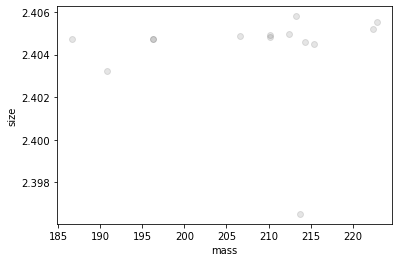

In [12]:
t1 = trackpy.filter_stubs(t,4)
print('before:', t['particle'].nunique())
print('after:', t1['particle'].nunique())
plt.figure()
trackpy.mass_size(t1.groupby('particle').mean());


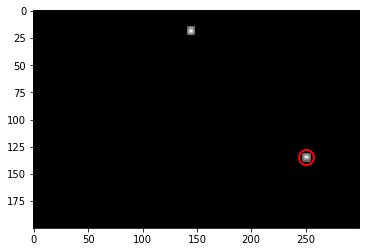

In [13]:
t2 = t1[((t1['mass'] > 20) & (t1['size'] < 3) &
         (t1['ecc'] < 0.3))]
plt.figure()
trackpy.annotate(t2[t2['frame'] == 0], sig[1,:,:,]);

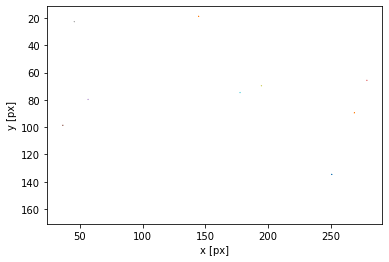

In [14]:
plt.figure()
trackpy.plot_traj(t2);

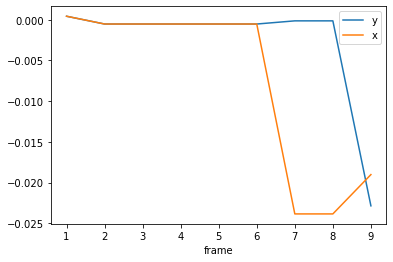

In [15]:
d = trackpy.compute_drift(t2)
d.plot()
plt.show()

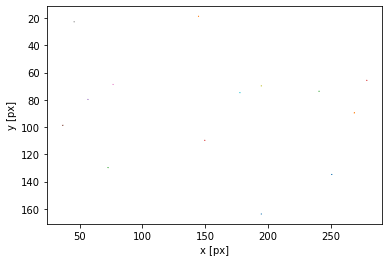

In [16]:
tm = trackpy.subtract_drift(t2.copy(), d)
ax = trackpy.plot_traj(tm)
plt.show()

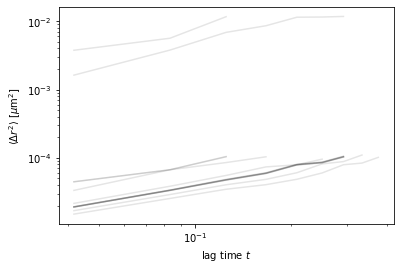

In [17]:
im = trackpy.imsd(tm, 100/285., 24)  # microns per pixel = 100/285., frames per second = 24
fig, ax = plt.subplots()
ax.plot(im.index, im, 'k-', alpha=0.1)  # black lines, semitransparent
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set_xscale('log')
ax.set_yscale('log')

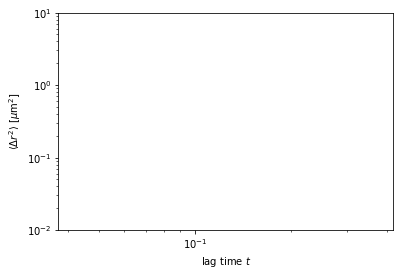

In [18]:
em = trackpy.emsd(tm, 100/285., 24) # microns per pixel = 100/285., frames per second = 24
fig, ax = plt.subplots()
ax.plot(em.index, em, 'o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set(ylim=(1e-2, 10));

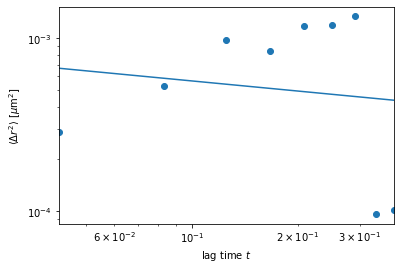

,n,A
msd,-0.193711,0.000362


In [19]:
plt.figure()
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
plt.xlabel('lag time $t$');
trackpy.utils.fit_powerlaw(em)  # performs linear best fit in log space, plots]

Below plot the particle size distribution from the simulation

Total number of particles =  30


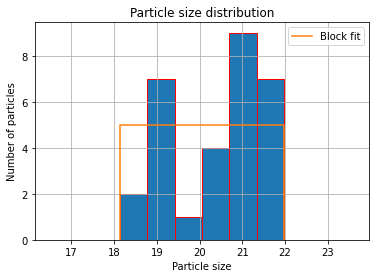

In [20]:
counts, bins, bars = plt.hist(list1,bins=6, edgecolor='red',density=False)
# print(bins)
# print(counts)
print('Total number of particles = ',int(sum(counts)))
numbins = len(bins)-1
bins_list = []
counts_list = []
for i in range(0,len(bins)-1):
    bins_list.append((bins[i] + bins[i+1])/2)
    counts_list.append(counts[i])
xvalues = [bins[0],bins[0],bins[-1],bins[-1]]
yvalues = [0,sum(counts)/numbins,sum(counts)/numbins,0]
plt.title("Particle size distribution")
plt.xlabel('Particle size')
plt.ylabel('Number of particles')
plt.xlim(xmin=a-2, xmax = b+2)
plt.plot(xvalues, yvalues, label='Block fit')
plt.legend()
plt.grid()

Add various fits to the histogram. Mind that the minimal number of bins = 3

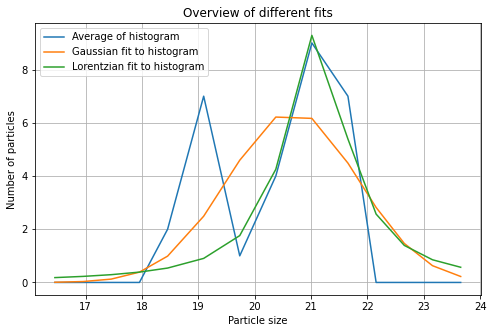

In [21]:
x_1 = np.array([bins_list[0]-2,bins_list[0]-1.5,bins_list[0]-1,bins_list[0]-0.5] + bins_list + [bins_list[-1]+0.5,bins_list[-1]+1,bins_list[-1]+1.5,bins_list[-1]+2])
# print(x_1)
# print(len(x))

y = np.array([0,0,0,0] + counts_list + [0,0,0,0])
# print(y)
# print(len(y))

mod1 = GaussianModel()
pars1 = mod1.guess(y, x=x_1)
out1 = mod1.fit(y, pars1, x=x_1)
# print(out1.fit_report(min_correl=0.5))

mod2 = LorentzianModel()
pars2 = mod2.guess(y, x=x_1)
out2 = mod2.fit(y, pars2, x=x_1)
# print(out2.fit_report(min_correl=0.6))
plt.figure(figsize=(8,5))
plt.plot(x_1,y,label='Average of histogram')
plt.plot(x_1, out1.best_fit,label='Gaussian fit to histogram')
plt.plot(x_1, out2.best_fit,label='Lorentzian fit to histogram')
plt.title("Overview of different fits")
plt.xlabel('Particle size')
plt.ylabel('Number of particles')
plt.legend()
plt.grid()
#https://lmfit.github.io/lmfit-py/builtin_models.html#example-1-fit-peak-data-to-gaussian-lorentzian-and-voigt-profiles